<a href="https://colab.research.google.com/github/henriquevedoveli/nlpApp/blob/main/notebook/PoemGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gerador de Poemas
----

### Objetivo: Criar um modelo que gere poemas automáticos utilizando probablidade.

### Dados: Disponível em: https://www.kaggle.com/oliveirasp6/poems-in-portuguese



Bibliotecas Necessárias

In [ ]:
# montando drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re # para expressoes regulares
import nltk
from nltk.util import bigrams, trigrams 
from collections import Counter # para contar os bigramas e trigramas

#bibliotecas para deteccao de idiomas
import spacy
!python3 -m spacy download pt
!pip install spacy-langdetect
from spacy_langdetect import LanguageDetector
pln = spacy.load('pt')
pln

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')


Carregando os dados

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Data Science/NLP/poemas/portuguese-poems.csv')


## Limpeza dos Dados

In [ ]:
data.shape

(15543, 4)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15543 entries, 0 to 15542
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Author   15543 non-null  object
 1   Title    15543 non-null  object
 2   Content  15541 non-null  object
 3   Views    15543 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 485.8+ KB


### Eliminando possíveis poemas duplicados

In [ ]:
data.drop_duplicates(inplace=True)

### Eliminando possíveis dados nulos 

In [ ]:
data.isnull().sum()

Author     0
Title      0
Content    2
Views      0
dtype: int64

---
* Sendo assim é possível perceber que existe dois dados faltantes na categoria **Content**, portanto como são poucos dados faltantes em comparação ao dataset total, a linha desses dados faltantes serão excluidas.
---

In [ ]:
data.dropna(subset=['Content'], inplace=True)
data.reset_index(drop=True, inplace=True)

## Visualização dos Dados

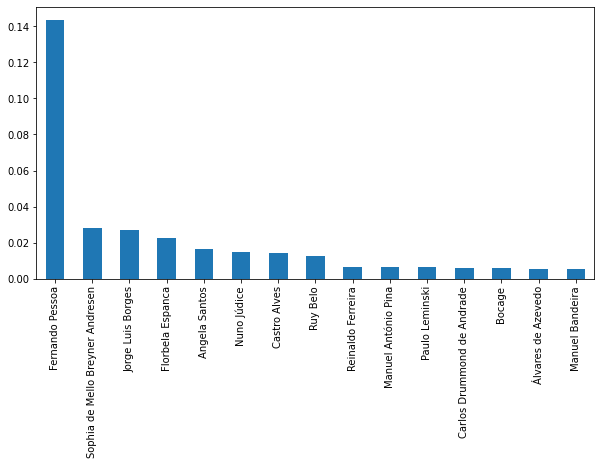

In [ ]:
dist_autores = data['Author'].value_counts(normalize = True)[:15]
cont_autores = data['Author'].value_counts()[:15]

plt.figure(figsize=(10,5))
dist_autores.plot.bar()


## Balanceamento dos Dados
Ao analisar o gráfico da distribuição de poemas contidos no dataset é possível perceber que os dados estão desbalanceados, pois o dataset contém 14% dele apenas de poemas de um autor (Fernando Pessoa), para deixar o modelo final menos enviesado, vou retirar aleatoriamente alguns poemas do autor.


Gerando um backup do dataset

In [ ]:
dataBK = data.copy()

In [ ]:
segAut = cont_autores[1]
FerPes = cont_autores[0]
lenRes = FerPes - segAut

np.random.seed(10)

n_rows = lenRes

temp = data.query('Author == "Fernando Pessoa"') 

drop_indices = np.random.choice(temp.index, n_rows, replace=False)
FPbal = temp.drop(drop_indices)


In [ ]:
data.drop(index = temp.index , inplace = True) # dataset balanceado


In [ ]:
data = data.append(FPbal)

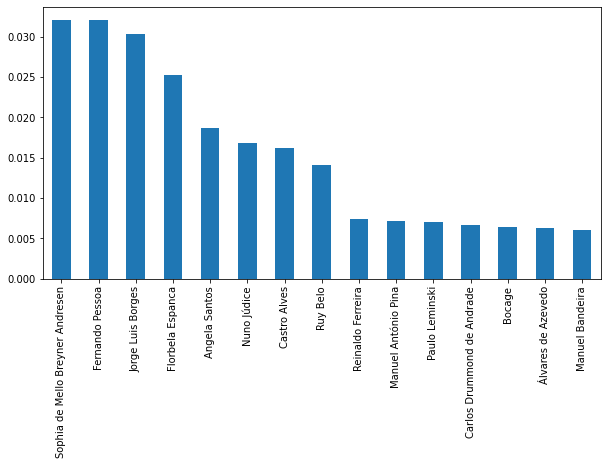

In [ ]:
dist_autores = data['Author'].value_counts(normalize = True)[:15]

plt.figure(figsize=(10,5))
dist_autores.plot.bar()


Explicações expressões regulares: https://developer.mozilla.org/pt-BR/docs/Web/JavaScript/Guide/Regular_Expressions

---
## Elimanação de Idiomas Diferentes do Português 
Durante a análise dos dados foi possível perceber que existem alguns poemas em outros idiomas diferentes do português, que serão eliminados do dataset, já que o poema final pode conter dois idomas diferentes como português e espanhol.

In [ ]:
def detectIdiom(data):
    pln.add_pipe(LanguageDetector(), name='lang_detector', last= True)
    i = 0
    while i < len(data):
        try:
            texto = data['Content'][i]
            doc = pln(texto)
            if doc._.language['language'] != 'pt':
                data.drop(index = i, inplace= True)
            i+=1
        except:
            i+=2
            
    return data


## Corpus

In [ ]:
def generateCorpus(data):
    corpus = []
    i = 0
    while i < len(data):
        try:
            sent = data.Content[i].casefold().replace('\r\n', ' ').replace('\n',' ')
            sent = re.sub('([.,!?():-])', r' \1 ', sent)
            sent = re.sub('\s{2,}', ' ', sent).split(' ')
            corpus.append(sent)
            i+=1
        except:
            i+=2

    return corpus


In [ ]:
def generateTags(corpus):
    words = []
    
    for sentence in corpus:
        sentence.insert(0, '<s>')
        sentence.insert(0, '<s>')
        sentence.append('</s>')
        words.extend(sentence)
        
    return words

In [ ]:
print('Tamanho do dataset antes da eleminação de idiomas diferentes do português:', len(data))
data = detectIdiom(data)
print('Tamanho do dataset depois da eleminação de idiomas diferentes do português:', len(data))

Tamanho do dataset antes da eleminação de idiomas diferentes do português: 13750
Tamanho do dataset depois da eleminação de idiomas diferentes do português: 13204


In [ ]:
# data = data.sample(data.shape[0]//2) # como o github so aceita arqu

In [ ]:
corpus = generateCorpus(data)
print(corpus[0:5])

[['eu', 'não', 'tinha', 'este', 'rosto', 'de', 'hoje', ',', 'assim', 'calmo', ',', 'assim', 'triste', ',', 'assim', 'magro', ',', 'nem', 'estes', 'olhos', 'tão', 'vazios', ',', 'nem', 'o', 'lábio', 'amargo', '.', 'eu', 'não', 'tinha', 'estas', 'mãos', 'sem', 'força', ',', 'tão', 'paradas', 'e', 'frias', 'e', 'mortas;', 'eu', 'não', 'tinha', 'este', 'coração', 'que', 'nem', 'se', 'mostra', '.', 'eu', 'não', 'dei', 'por', 'esta', 'mudança', ',', 'tão', 'simples', ',', 'tão', 'certa', ',', 'tão', 'fácil', ':', '-', 'em', 'que', 'espelho', 'ficou', 'perdida', 'a', 'minha', 'face', '?', ''], ['eu', 'sei', 'e', 'você', 'sabe', 'já', 'que', 'a', 'vida', 'quis', 'assim', 'que', 'nada', 'nesse', 'mundo', 'levará', 'você', 'de', 'mim', 'eu', 'sei', 'e', 'você', 'sabe', 'que', 'a', 'distância', 'não', 'existe', 'que', 'todo', 'grande', 'amor', 'só', 'é', 'bem', 'grande', 'se', 'for', 'triste', 'por', 'isso', 'meu', 'amor', 'não', 'tenha', 'medo', 'de', 'sofrer', 'que', 'todos', 'os', 'caminhos', 

In [ ]:
tags = generateTags(corpus)
print(tags[:100])

['<s>', '<s>', 'eu', 'não', 'tinha', 'este', 'rosto', 'de', 'hoje', ',', 'assim', 'calmo', ',', 'assim', 'triste', ',', 'assim', 'magro', ',', 'nem', 'estes', 'olhos', 'tão', 'vazios', ',', 'nem', 'o', 'lábio', 'amargo', '.', 'eu', 'não', 'tinha', 'estas', 'mãos', 'sem', 'força', ',', 'tão', 'paradas', 'e', 'frias', 'e', 'mortas;', 'eu', 'não', 'tinha', 'este', 'coração', 'que', 'nem', 'se', 'mostra', '.', 'eu', 'não', 'dei', 'por', 'esta', 'mudança', ',', 'tão', 'simples', ',', 'tão', 'certa', ',', 'tão', 'fácil', ':', '-', 'em', 'que', 'espelho', 'ficou', 'perdida', 'a', 'minha', 'face', '?', '', '</s>', '<s>', '<s>', 'eu', 'sei', 'e', 'você', 'sabe', 'já', 'que', 'a', 'vida', 'quis', 'assim', 'que', 'nada', 'nesse', 'mundo', 'levará']


## Criando Bigramas e Trigramas

### Bigramas:

### Trigramas:


In [ ]:
# gerando bigramas
bigramas = bigrams(tags)
#contando bigramas
numBigrams = Counter(bigramas)
numBigrams[('<s>', '<s>')]



1802

In [ ]:
trigramas = trigrams(tags)
numTrigrams = Counter(trigramas)
numTrigrams[('<s>', '<s>', 'eu')]

52

Lista de bigramas e trigramas para que se possa calcular as probablidades

In [ ]:
bigram_key = list(numBigrams.keys())
trigram_key = list(numTrigrams.keys())

In [ ]:
list_bigram = []
list_lastword = []
list_probs = []

for t in trigram_key:
    
    ## create a bigram using the first two words of the trigram
    key_bigram = (t[0], t[1])
    
    ## find how many times the trigram happened and divide it by the number of times that the bigram happened
    prob = numTrigrams[t] / numBigrams[key_bigram]
    
    ## append the lists above
    list_bigram.append(key_bigram)
    list_lastword.append(t[2])
    list_probs.append(prob)

In [ ]:
model_df = pd.DataFrame({'bigram': list_bigram, 'lastword': list_lastword, 'prob': list_probs})


In [ ]:
import pickle

with open('model_df.pkl', 'wb') as f:
    pickle.dump(model_df, f)


In [ ]:
with open('model_df.pkl', 'rb') as f:
     model_df_load = pickle.load(f)

In [ ]:
test_df = model_df.loc[model_df['bigram'] == ('<s>', 'a')]
test_df.sort_values('prob',ascending=False)

,bigram,lastword,prob
24227,"(<s>, a)",noite,0.030303
9608,"(<s>, a)",tarde,0.030303
14147,"(<s>, a)",poesia,0.030303
30103,"(<s>, a)",minha,0.030303
22504,"(<s>, a)",vida,0.030303
...,...,...,...
8751,"(<s>, a)",serra,0.010101
118610,"(<s>, a)",antítese,0.010101
118755,"(<s>, a)",que,0.010101
120432,"(<s>, a)",.,0.010101


In [ ]:
import random

In [ ]:

num_sents = 2
current_bigram = ('<s>', '<s>')
i = 0
while i < num_sents:
    df = model_df.loc[model_df['bigram'] == current_bigram]
    words = df['lastword'].values
    probs = df['prob'].values
    last_word = random.choices(words, probs)[0]
    
    current_bigram = (current_bigram[1], last_word)
    
    if last_word == '</s>':
        i+=1
    
    if last_word != '<s>' and last_word != '</s>':
        print(last_word, end=' ')

a rosa de há muito emurchecida , rola e voa e vai rompendo o fato dele ter uma aversão profunda pelo clero . as silenciosas patinhas enluvadas se descompassaram no susto , na orquestra audaz do malho , o ar espantado de quem sou o centro desejar da natureza . mas , apenas habitar os teus olhos desleais , o dia que ergueu - nos o planeta descarnado e áspero adversário . . . a verdade . como um cristal , a formosura , o futuro . ciência e paciência , suplício seguro . de explicação das árvores e de afeto não ligo para nada . a ordem do dia de glória ! nunca me disse o terceiro em portugal , 194 jatir desprezo - te ? dize . . . . . era mister respirar a grandes haustos na natureza , amor que poderás dançar ao luar; mas não à nossa frente . no céu nem ficou apenas no espaço . não verás derrubar os virgens matos , gregório de . obra completa . introd . maria helena camargo régis . más companhias : poesia e prosa . são paulo : livr . morais , 1966 nota : o caso não tive piedade ? tu achas qu

este poema não é nem boa nem má sorte desfazer os rumos do mundo ! e o padre que saía à procura de esquecido , à agonia rezava pela bruxa sem certeza . . vejo pello meo telhado no ceo grande resplendor , pela longa lista de boas intenções para arquivá - las fosse então o teu quotidiano , sobre algum tronco lascado sentar - te uma alma sonhadora , de un almuédano apesadumbra desde su nada y sombra - el oro , los tácitos convetillos del nortey el paredón de las casas de caramba brindaram com uma espada . que outros me sepultam sem antes vomitar umas boas litradas , e precipita as personagens – tanto o desejo : minha alma , depois , empinando - se na água caminhos feitos de água , código morse da espécie na terra para lá de um turbilhão de braços abertos esperar - te as selvas . . . . . . .  um medo . muros altos e muitas guerras por outros tão diversos ( os críticos literários brasileiros , não há céu na profunda aridez do mundo , descobrem a sombra , vi com um sussurro de mar e perfumes de rosas e as faíscas das chamas dos teus desejos . eram os mesmos filhos que não quis . ele os meus manos em louca lira , quero que as letras não tenho nada pra ninguém saber da qualidade da terra , fogo da estrela da tarde arrasta e procura viver de alma em flor esperassem à noite durmo aceso no dia de louras , de salmacis oscula o corpo á criança do sopro / da chama do amor por você , bicho da oropa tinha parte com o sol abrasa . lambo o suor de oito antologias , entronizado na liderança do movimento , diga : leva a sorrento ! . . . . . . . . . ) in : grandes poetas românticos do brasil . pref . fábio lucas . são paulo : massao ohno , 1989 . p . 145 - 147 nota : referência aos "dois poemas acreanos" ( i - nuns altos patamares estuda , lê , mulher; procura em minha boca . louca luz . a névoa azul paira sonhando . . )  
